# Generalized convolutions in JAX

<!--* freshness: { reviewed: '2024-04-08' } *-->

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax/blob/main/docs/notebooks/convolutions.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/jax-ml/jax/blob/main/docs/notebooks/convolutions.ipynb)

JAX provides a number of interfaces to compute convolutions across data, including:

- {func}`jax.numpy.convolve` (also {func}`jax.numpy.correlate`)
- {func}`jax.scipy.signal.convolve` (also {func}`~jax.scipy.signal.correlate`)
- {func}`jax.scipy.signal.convolve2d` (also {func}`~jax.scipy.signal.correlate2d`)
- {func}`jax.lax.conv_general_dilated`

For basic convolution operations, the `jax.numpy` and `jax.scipy` operations are usually sufficient. If you want to do more general batched multi-dimensional convolution, the `jax.lax` function is where you should start.

## Basic one-dimensional convolution

Basic one-dimensional convolution is implemented by {func}`jax.numpy.convolve`, which provides a JAX interface for {func}`numpy.convolve`. Here is a simple example of 1D smoothing implemented via a convolution:

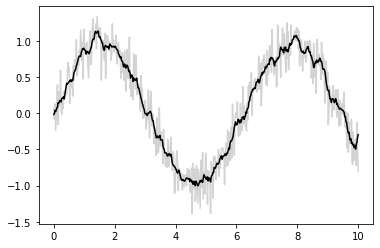

In [18]:
import matplotlib.pyplot as plt

from jax import random
import jax.numpy as jnp
import numpy as np

key = random.key(1701)

x = jnp.linspace(0, 10, 500)
y = jnp.sin(x) + 0.2 * random.normal(key, shape=(500,))

window = jnp.ones(10) / 10
y_smooth = jnp.convolve(y, window, mode='same')

plt.plot(x, y, 'lightgray')
plt.plot(x, y_smooth, 'black');

The `mode` parameter controls how boundary conditions are treated; here we use `mode='same'` to ensure that the output is the same size as the input.

For more information, see the {func}`jax.numpy.convolve` documentation, or the documentation associated with the original {func}`numpy.convolve` function.

## Basic N-dimensional convolution

For *N*-dimensional convolution, {func}`jax.scipy.signal.convolve` provides a similar interface to that of {func}`jax.numpy.convolve`, generalized to *N* dimensions.

For example, here is a simple approach to de-noising an image based on convolution with a Gaussian filter:

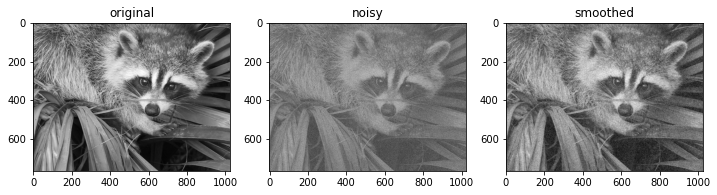

In [19]:
from scipy import datasets
import jax.scipy as jsp

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Load a sample image; compute mean() to convert from RGB to grayscale.
image = jnp.array(datasets.face().mean(-1))
ax[0].imshow(image, cmap='binary_r')
ax[0].set_title('original')

# Create a noisy version by adding random Gaussian noise
key = random.key(1701)
noisy_image = image + 50 * random.normal(key, image.shape)
ax[1].imshow(noisy_image, cmap='binary_r')
ax[1].set_title('noisy')

# Smooth the noisy image with a 2D Gaussian smoothing kernel.
x = jnp.linspace(-3, 3, 7)
window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
smooth_image = jsp.signal.convolve(noisy_image, window, mode='same')
ax[2].imshow(smooth_image, cmap='binary_r')
ax[2].set_title('smoothed');

Like in the one-dimensional case, we use `mode='same'` to specify how we would like edges to be handled. For more information on available options in *N*-dimensional convolutions, see the {func}`jax.scipy.signal.convolve` documentation.

## General convolutions

For the more general types of batched convolutions often useful in the context of building deep neural networks, JAX and XLA offer the very general N-dimensional __conv_general_dilated__ function, but it's not very obvious how to use it.  We'll give some examples of the common use-cases.

A survey of the family of convolutional operators, [a guide to convolutional arithmetic](https://arxiv.org/abs/1603.07285), is highly recommended reading!

Let's define a simple diagonal edge kernel:

Edge Conv kernel:


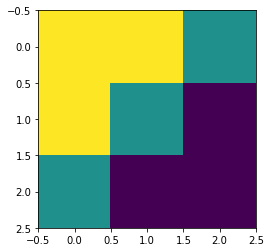

In [20]:
# 2D kernel - HWIO layout
kernel = jnp.zeros((3, 3, 3, 3), dtype=jnp.float32)
kernel += jnp.array([[1, 1, 0],
                     [1, 0,-1],
                     [0,-1,-1]])[:, :, jnp.newaxis, jnp.newaxis]

print("Edge Conv kernel:")
plt.imshow(kernel[:, :, 0, 0]);

And we'll make a simple synthetic image:

Original Image:


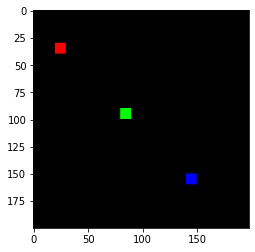

In [21]:
# NHWC layout
img = jnp.zeros((1, 200, 198, 3), dtype=jnp.float32)
for k in range(3):
  x = 30 + 60*k
  y = 20 + 60*k
  img = img.at[0, x:x+10, y:y+10, k].set(1.0)

print("Original Image:")
plt.imshow(img[0]);

### lax.conv and lax.conv_with_general_padding

These are the simple convenience functions for convolutions

️⚠️ The convenience `lax.conv`, `lax.conv_with_general_padding` helper functions assume __NCHW__ images and __OIHW__ kernels.

out shape:  (1, 3, 200, 198)
First output channel:


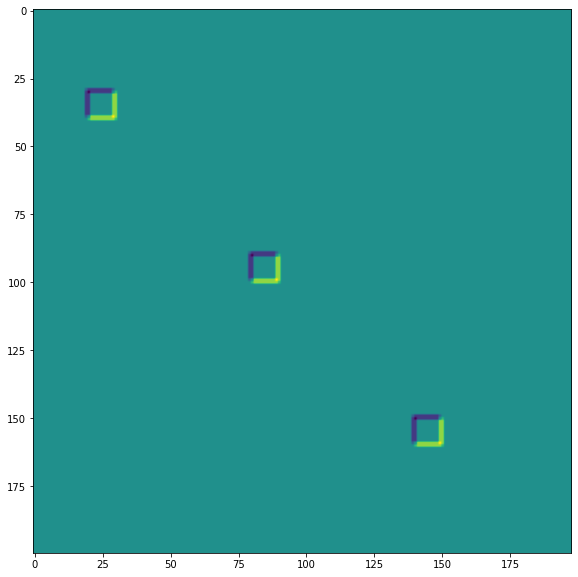

In [22]:
from jax import lax
out = lax.conv(jnp.transpose(img,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (1, 1),  # window strides
               'SAME') # padding mode
print("out shape: ", out.shape)
print("First output channel:")
plt.figure(figsize=(10,10))
plt.imshow(np.array(out)[0,0,:,:]);

out shape:  (1, 3, 202, 200)
First output channel:


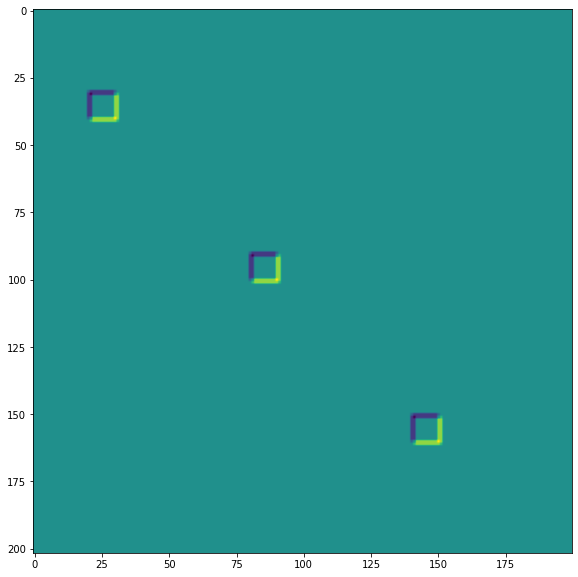

In [23]:
out = lax.conv_with_general_padding(
  jnp.transpose(img,[0,3,1,2]),    # lhs = NCHW image tensor
  jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
  (1, 1),  # window strides
  ((2,2),(2,2)), # general padding 2x2
  (1,1),  # lhs/image dilation
  (1,1))  # rhs/kernel dilation
print("out shape: ", out.shape)
print("First output channel:")
plt.figure(figsize=(10,10))
plt.imshow(np.array(out)[0,0,:,:]);

### Dimension Numbers define dimensional layout for conv_general_dilated

The important argument is the 3-tuple of axis layout arguments:
(Input Layout, Kernel Layout, Output Layout)
 - __N__ - batch dimension
 - __H__ - spatial height
 - __W__ - spatial width
 - __C__ - channel dimension
 - __I__ - kernel _input_ channel dimension
 - __O__ - kernel _output_ channel dimension

⚠️ To demonstrate the flexibility of dimension numbers we choose a __NHWC__ image and __HWIO__ kernel convention for `lax.conv_general_dilated` below.

In [24]:
dn = lax.conv_dimension_numbers(img.shape,     # only ndim matters, not shape
                                kernel.shape,  # only ndim matters, not shape
                                ('NHWC', 'HWIO', 'NHWC'))  # the important bit
print(dn)

ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2))


#### SAME padding, no stride, no dilation

out shape:  (1, 200, 198, 3)
First output channel:


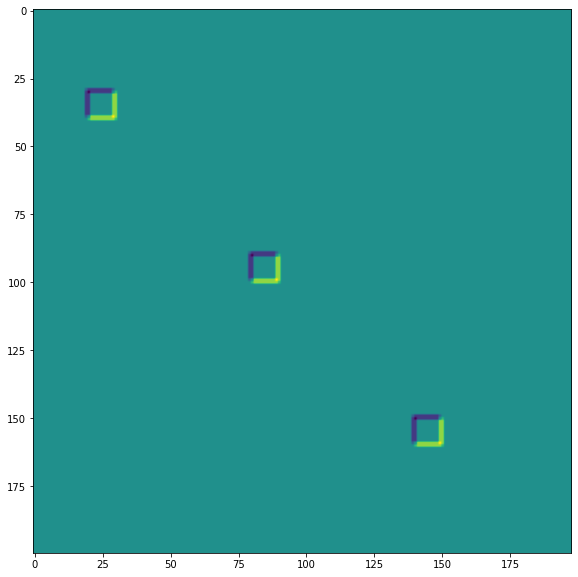

In [25]:
out = lax.conv_general_dilated(img,    # lhs = image tensor
                               kernel, # rhs = conv kernel tensor
                               (1,1),  # window strides
                               'SAME', # padding mode
                               (1,1),  # lhs/image dilation
                               (1,1),  # rhs/kernel dilation
                               dn)     # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape)
print("First output channel:")
plt.figure(figsize=(10,10))
plt.imshow(np.array(out)[0,:,:,0]);

#### VALID padding, no stride, no dilation

out shape:  (1, 198, 196, 3) DIFFERENT from above!
First output channel:


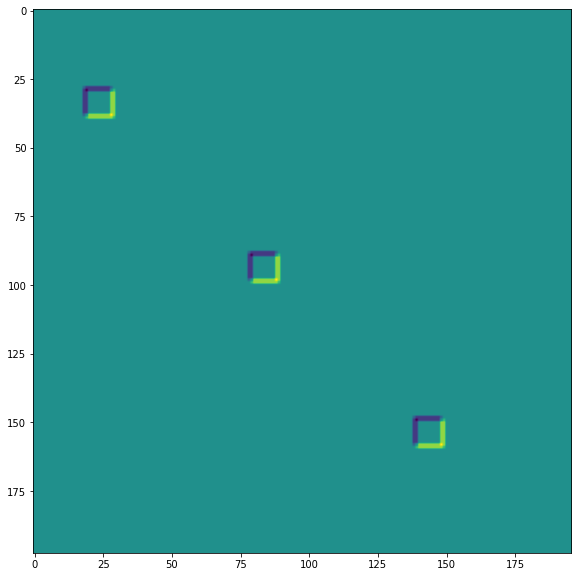

In [26]:
out = lax.conv_general_dilated(img,     # lhs = image tensor
                               kernel,  # rhs = conv kernel tensor
                               (1,1),   # window strides
                               'VALID', # padding mode
                               (1,1),   # lhs/image dilation
                               (1,1),   # rhs/kernel dilation
                               dn)      # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape, "DIFFERENT from above!")
print("First output channel:")
plt.figure(figsize=(10,10))
plt.imshow(np.array(out)[0,:,:,0]);

#### SAME padding, 2,2 stride, no dilation

out shape:  (1, 100, 99, 3)  <-- half the size of above
First output channel:


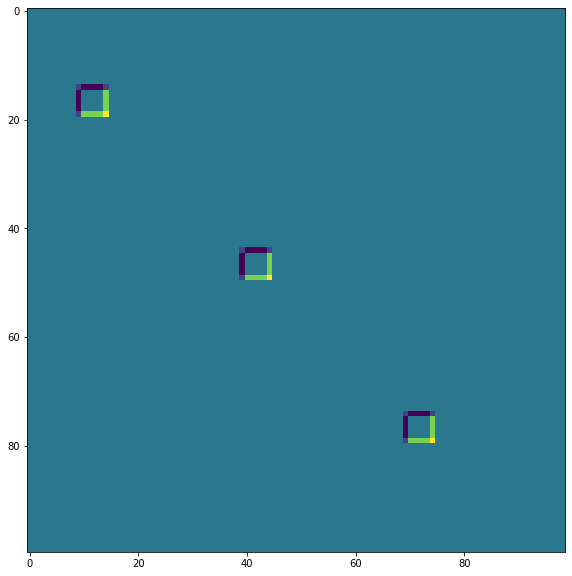

In [27]:
out = lax.conv_general_dilated(img,    # lhs = image tensor
                               kernel, # rhs = conv kernel tensor
                               (2,2),  # window strides
                               'SAME', # padding mode
                               (1,1),  # lhs/image dilation
                               (1,1),  # rhs/kernel dilation
                               dn)     # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape, " <-- half the size of above")
plt.figure(figsize=(10,10))
print("First output channel:")
plt.imshow(np.array(out)[0,:,:,0]);

#### VALID padding, no stride, rhs kernel dilation ~ Atrous convolution (excessive to illustrate)

out shape:  (1, 176, 174, 3)
First output channel:


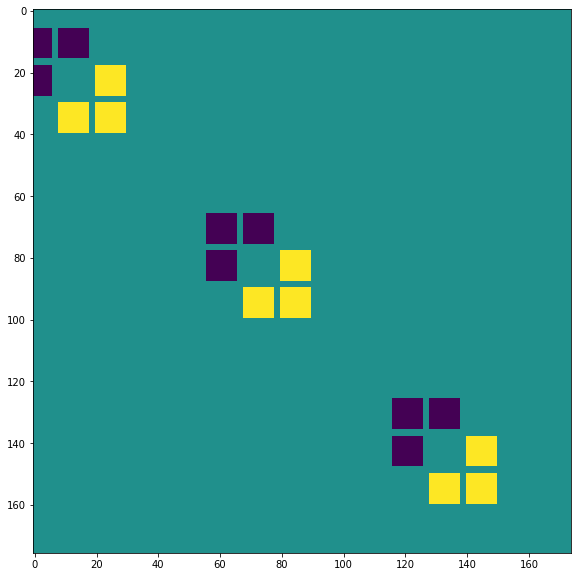

In [28]:
out = lax.conv_general_dilated(img,     # lhs = image tensor
                               kernel,  # rhs = conv kernel tensor
                               (1,1),   # window strides
                               'VALID', # padding mode
                               (1,1),   # lhs/image dilation
                               (12,12), # rhs/kernel dilation
                               dn)      # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape)
plt.figure(figsize=(10,10))
print("First output channel:")
plt.imshow(np.array(out)[0,:,:,0]);

#### VALID padding, no stride, lhs=input dilation  ~ Transposed Convolution

out shape:  (1, 397, 393, 3) <-- larger than original!
First output channel:


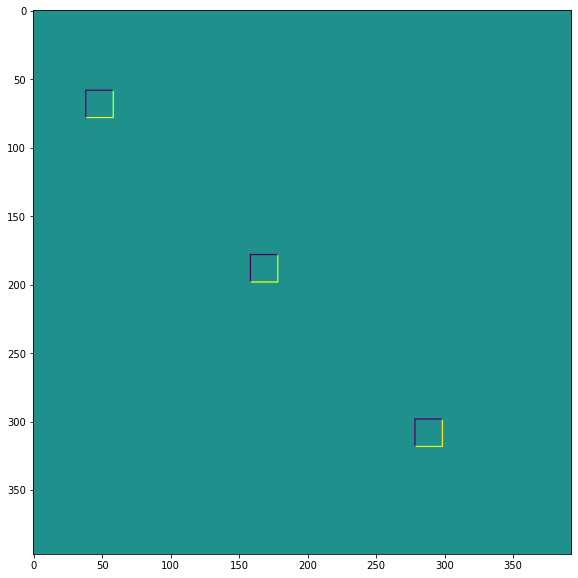

In [29]:
out = lax.conv_general_dilated(img,               # lhs = image tensor
                               kernel,            # rhs = conv kernel tensor
                               (1,1),             # window strides
                               ((0, 0), (0, 0)),  # padding mode
                               (2,2),             # lhs/image dilation
                               (1,1),             # rhs/kernel dilation
                               dn)                # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape, "<-- larger than original!")
plt.figure(figsize=(10,10))
print("First output channel:")
plt.imshow(np.array(out)[0,:,:,0]);

We can use the last to, for instance, implement _transposed convolutions_:

out shape:  (1, 400, 396, 3) <-- transposed_conv
First output channel:


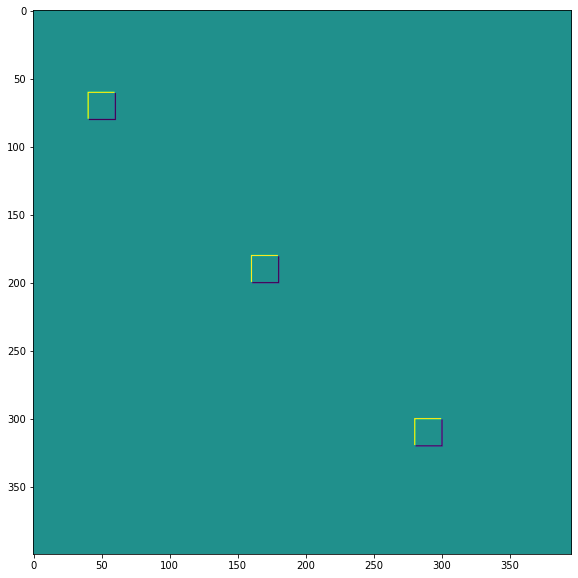

In [30]:
# The following is equivalent to tensorflow:
# N,H,W,C = img.shape
# out = tf.nn.conv2d_transpose(img, kernel, (N,2*H,2*W,C), (1,2,2,1))

# transposed conv = 180deg kernel rotation plus LHS dilation
# rotate kernel 180deg:
kernel_rot = jnp.rot90(jnp.rot90(kernel, axes=(0,1)), axes=(0,1))
# need a custom output padding:
padding = ((2, 1), (2, 1))
out = lax.conv_general_dilated(img,     # lhs = image tensor
                               kernel_rot,  # rhs = conv kernel tensor
                               (1,1),   # window strides
                               padding, # padding mode
                               (2,2),   # lhs/image dilation
                               (1,1),   # rhs/kernel dilation
                               dn)      # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape, "<-- transposed_conv")
plt.figure(figsize=(10,10))
print("First output channel:")
plt.imshow(np.array(out)[0,:,:,0]);

### 1D Convolutions

You aren't limited to 2D convolutions, a simple 1D demo is below:

in shapes: (1, 200, 2) (3, 2, 2)
ConvDimensionNumbers(lhs_spec=(0, 2, 1), rhs_spec=(2, 1, 0), out_spec=(0, 2, 1))
out shape:  (1, 200, 2)


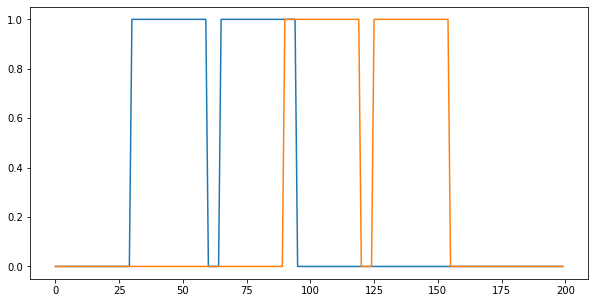

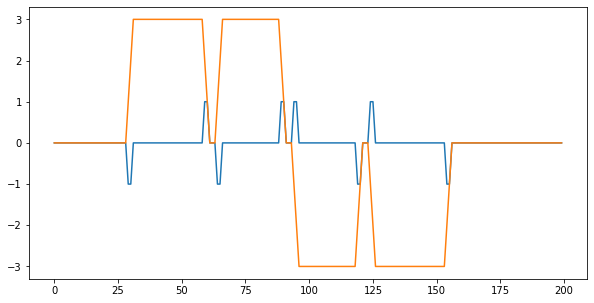

In [31]:
# 1D kernel - WIO layout
kernel = jnp.array([[[1, 0, -1], [-1,  0,  1]],
                    [[1, 1,  1], [-1, -1, -1]]],
                    dtype=jnp.float32).transpose([2,1,0])
# 1D data - NWC layout
data = np.zeros((1, 200, 2), dtype=jnp.float32)
for i in range(2):
  for k in range(2):
      x = 35*i + 30 + 60*k
      data[0, x:x+30, k] = 1.0

print("in shapes:", data.shape, kernel.shape)

plt.figure(figsize=(10,5))
plt.plot(data[0]);
dn = lax.conv_dimension_numbers(data.shape, kernel.shape,
                                ('NWC', 'WIO', 'NWC'))
print(dn)

out = lax.conv_general_dilated(data,   # lhs = image tensor
                               kernel, # rhs = conv kernel tensor
                               (1,),   # window strides
                               'SAME', # padding mode
                               (1,),   # lhs/image dilation
                               (1,),   # rhs/kernel dilation
                               dn)     # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape)
plt.figure(figsize=(10,5))
plt.plot(out[0]);

### 3D Convolutions

in shapes: (1, 30, 30, 30, 1) (3, 3, 3, 1, 1)
ConvDimensionNumbers(lhs_spec=(0, 4, 1, 2, 3), rhs_spec=(4, 3, 0, 1, 2), out_spec=(0, 4, 1, 2, 3))
out shape:  (1, 30, 30, 30, 1)


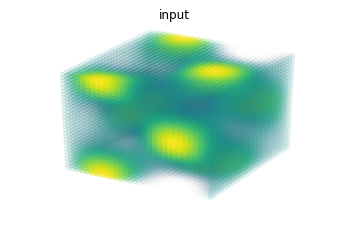

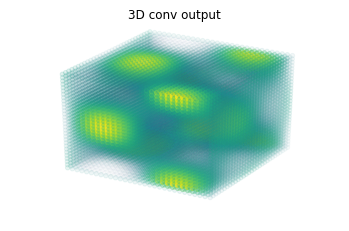

In [32]:
import matplotlib as mpl

# Random 3D kernel - HWDIO layout
kernel = jnp.array([
  [[0, 0,  0], [0,  1,  0], [0,  0,   0]],
  [[0, -1, 0], [-1, 0, -1], [0,  -1,  0]],
  [[0, 0,  0], [0,  1,  0], [0,  0,   0]]],
  dtype=jnp.float32)[:, :, :, jnp.newaxis, jnp.newaxis]

# 3D data - NHWDC layout
data = jnp.zeros((1, 30, 30, 30, 1), dtype=jnp.float32)
x, y, z = np.mgrid[0:1:30j, 0:1:30j, 0:1:30j]
data += (jnp.sin(2*x*jnp.pi)*jnp.cos(2*y*jnp.pi)*jnp.cos(2*z*jnp.pi))[None,:,:,:,None]

print("in shapes:", data.shape, kernel.shape)
dn = lax.conv_dimension_numbers(data.shape, kernel.shape,
                                ('NHWDC', 'HWDIO', 'NHWDC'))
print(dn)

out = lax.conv_general_dilated(data,    # lhs = image tensor
                               kernel,  # rhs = conv kernel tensor
                               (1,1,1), # window strides
                               'SAME',  # padding mode
                               (1,1,1), # lhs/image dilation
                               (1,1,1), # rhs/kernel dilation
                               dn)      # dimension_numbers
print("out shape: ", out.shape)

# Make some simple 3d density plots:
def make_alpha(cmap):
  my_cmap = cmap(jnp.arange(cmap.N))
  my_cmap[:,-1] = jnp.linspace(0, 1, cmap.N)**3
  return mpl.colors.ListedColormap(my_cmap)
my_cmap = make_alpha(plt.cm.viridis)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=data.ravel(), cmap=my_cmap)
ax.axis('off')
ax.set_title('input')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=out.ravel(), cmap=my_cmap)
ax.axis('off')
ax.set_title('3D conv output');